In [1]:
import pandas as pd
import cufflinks as cf
import plotly.offline
import plotly.graph_objs as go  
import mytools.regression as reg
import mytools.date as dt

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## Italian intensive care cases 

In [2]:
# loading the data
df = pd.read_csv('italy-intensive_care.csv')
a = list((dt.day_of_year_to_date(v)).strftime("%d %b") for v in df['day'])
df.index = a
# display the table
pd.DataFrame(df['intensive care'])



,intensive care
25 Feb,27
26 Feb,35
27 Feb,36
28 Feb,56
29 Feb,64
01 Mar,105
02 Mar,140
03 Mar,166
04 Mar,229
05 Mar,295


## Fitting intensive care data with exponential and logistic models

The exponential model is:

$$y = e^{k(x-x_0)} + y_0$$

where $k, x_0, y_0$ are the parameters to estimate.

For the logistic model:

$$y = \frac{c}{1+e^{-k(x-x_0)}} + y_0$$

where $c, k, x_0, y_0$ are the parameters to estimate.

In [3]:
x_orig = df['day']
y_orig = df['intensive care']

sigm_model, xp, pxp = reg.fit_sigmoid(x_orig, y_orig, verbose=True)
flex = reg.sigmoid_get_flex(sigm_model)

exp_model, exp_xp, exp_pxp = reg.fit_exponential(x_orig, y_orig, upper=1.25, verbose=True)


`ftol` termination condition is satisfied.
Function evaluations 18, initial cost 1.3892e+00, final cost 4.6901e-04, first-order optimality 1.09e-08.
        Sigmoid model
        x0 = 66.9894743685211
        y0 = 10.744363529183987
        c = 1085.4874378851223
        k = 0.3511726187832844
        asymptot = 1096.2318014143063
        flex = 66.9894743685211, 553.4880824717451
        
[0.65      0.4378187 1.       ]
`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 5.4843e+00, final cost 2.5157e-03, first-order optimality 2.51e-08.
            Exponential model
            x0 = 27.57783416115634
            y0 = -82.72177126103223
            k = 0.16280058720769452
            


In [4]:
# preparing table with predictions
d_max = df['day'].max()
d_min = df['day'].min()
f_days = range(d_min - 4, d_max + 4, 1)

f_exp = reg.exponential(exp_model, f_days)
f_sigm = reg.sigmoid(sigm_model, f_days)
f_df = pd.DataFrame({'day' : f_days, 'exp' : f_exp, 'sigm' : f_sigm})
f_df.index = dt.day_of_year_to_string(f_days)

df_final = pd.merge(df, f_df, on='day', how='outer', sort=True)
df_final.index = dt.day_of_year_to_string(f_days)
df_final

,day,intensive care,exp,sigm
21 Feb,51,NaN,-37.429231,14.683978
22 Feb,52,NaN,-29.421419,16.332968
23 Feb,53,NaN,-19.997810,18.667115
24 Feb,54,NaN,-8.908089,21.966014
25 Feb,55,27.0,4.142318,26.618284
26 Feb,56,35.0,19.500062,33.159049
27 Feb,57,36.0,37.573086,42.315351
28 Feb,58,56.0,58.841457,55.056058
29 Feb,59,64.0,83.870119,72.636427
01 Mar,60,105.0,113.323898,96.616428


In [5]:
fig = df_final[['exp', 'sigm', 'intensive care']].iplot(theme="white", title="Intensive care cases", size=4, yTitle='case', mode='lines+markers', asFigure=True)
fig.data[2].mode='markers'
fig.data[2].marker.size = 8
fig.show()

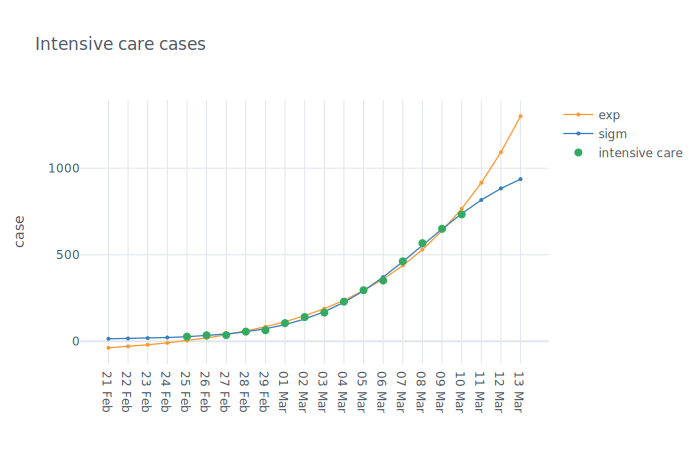

In [6]:
fig.show('svg')